<a href="https://colab.research.google.com/github/roshan-eng/iGEM_WebApp/blob/master/Pokeball_Factories_and_Childhood_Asthma_Research_Analysis_Plan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load the datasets
city_df = pd.read_csv('sample_data/city.csv')
hospital_df = pd.read_csv('sample_data/hospital.csv')

print("City data shape:", city_df.shape)
print("Hospital data shape:", hospital_df.shape)
print("\nCity data preview:")
print(city_df.head())
print("\nHospital data preview:")
print(hospital_df.head())

City data shape: (50, 35)
Hospital data shape: (177, 17)

City data preview:
              city  population  lawchange  factory_0  factory_1  factory_2  \
0      Azalea Town      319143      False          2          3          3   
1  Blackthorn City      192382       True          0          0          0   
2    Carolyn Beach      729977      False          6          6          6   
3     Celadon City      318014      False          2          2          3   
4    Cerulean City      246201      False          0          0          0   

   factory_3  factory_4  factory_5  factory_6  factory_7  factory_8  \
0          3          3          3          3          3          3   
1          0          0          0          0          0          1   
2          6          6          6          6          6          6   
3          3          3          4          4          4          4   
4          0          0          0          0          0          1   

   factory_9  factory_10  f

In [3]:
# Exploration and Cleaning
# Check for missing values
print("Missing values in city data:")
print(city_df.isnull().sum())
print("\nMissing values in hospital data:")
print(hospital_df.isnull().sum())

# Explore the lawchange variable (treatment indicator)
print("\nLaw change distribution:")
print(city_df['lawchange'].value_counts())
print(f"\nProportion of cities with lawchange: {city_df['lawchange'].mean():.3f}")

# Check unique cities in both datasets
city_names_city = set(city_df['city'].unique())
city_names_hospital = set([hospital.split(' ')[0] + ' ' + hospital.split(' ')[1]
                          for hospital in hospital_df['hospital'].unique()])

print(f"\nUnique cities in city data: {len(city_names_city)}")
print(f"Unique cities in hospital data: {len(city_names_hospital)}")

# Extract city names from hospital data for matching
hospital_df['city'] = hospital_df['hospital'].str.extract(r'^(.+?)\s+\w+$')[0]
print(f"\nSample of extracted city names: {hospital_df['city'].head().tolist()}")

Missing values in city data:
city             0
population       0
lawchange        0
factory_0        0
factory_1        0
factory_2        0
factory_3        0
factory_4        0
factory_5        0
factory_6        0
factory_7        0
factory_8        0
factory_9        0
factory_10       0
factory_11       0
factory_12       0
factory_13       0
factory_14       0
factory_15       0
production_0     0
production_1     0
production_2     0
production_3     0
production_4     0
production_5     0
production_6     0
production_7     0
production_8     0
production_9     0
production_10    0
production_11    0
production_12    0
production_13    0
production_14    0
production_15    0
dtype: int64

Missing values in hospital data:
hospital    0
cases0      0
cases1      0
cases2      0
cases3      0
cases4      0
cases5      0
cases6      0
cases7      0
cases8      0
cases9      0
cases10     0
cases11     0
cases12     0
cases13     0
cases14     0
cases15     0
dtype: int64

Law cha

In [4]:
# Reshape Data to Long Format
# Reshape city data from wide to long format
city_long = pd.melt(city_df,
                    id_vars=['city', 'population', 'lawchange'],
                    value_vars=[f'factory_{i}' for i in range(16)] + [f'production_{i}' for i in range(16)],
                    var_name='variable', value_name='value')

# Extract year and variable type
city_long['year'] = city_long['variable'].str.extract(r'_(\d+)$').astype(int)
city_long['var_type'] = city_long['variable'].str.extract(r'^(\w+)_\d+$')

# Pivot to have factories and production as separate columns
city_panel = city_long.pivot_table(index=['city', 'population', 'lawchange', 'year'],
                                   columns='var_type', values='value').reset_index()

# Reshape hospital data from wide to long format
hospital_long = pd.melt(hospital_df,
                        id_vars=['hospital', 'city'],
                        value_vars=[f'cases{i}' for i in range(16)],
                        var_name='year_var', value_name='asthma_cases')

# Extract year from variable name
hospital_long['year'] = hospital_long['year_var'].str.extract(r'cases(\d+)').astype(int)
hospital_long = hospital_long.drop('year_var', axis=1)

print("City panel data shape:", city_panel.shape)
print("Hospital long data shape:", hospital_long.shape)
print("\nCity panel preview:")
print(city_panel.head())
print("\nHospital long preview:")
print(hospital_long.head())

City panel data shape: (800, 6)
Hospital long data shape: (2832, 4)

City panel preview:
var_type         city  population  lawchange  year  factory  production
0         Azalea Town      319143      False     0      2.0   1239106.0
1         Azalea Town      319143      False     1      3.0   1548564.0
2         Azalea Town      319143      False     2      3.0   1281339.0
3         Azalea Town      319143      False     3      3.0   1460790.0
4         Azalea Town      319143      False     4      3.0   1450929.0

Hospital long preview:
                  hospital             city  asthma_cases  year
0      Azalea Town Chansey      Azalea Town          1111     0
1   Azalea Town Hitmonchan      Azalea Town          1633     0
2     Azalea Town Shellder      Azalea Town          1671     0
3  Blackthorn City Chansey  Blackthorn City           350     0
4   Blackthorn City Golbat  Blackthorn City           821     0


In [5]:
# Aggregate Hospital Data by City
# Aggregate asthma cases by city and year
city_asthma = hospital_long.groupby(['city', 'year'])['asthma_cases'].sum().reset_index()

# Merge with city panel data
analysis_df = pd.merge(city_panel, city_asthma, on=['city', 'year'], how='left')

# Handle missing asthma cases (cities without hospitals)
analysis_df['asthma_cases'] = analysis_df['asthma_cases'].fillna(0)

# Create asthma rate per 100,000 population
analysis_df['asthma_rate'] = (analysis_df['asthma_cases'] / analysis_df['population']) * 100000

# Create treatment indicators
analysis_df['treated'] = analysis_df['lawchange'].astype(int)
analysis_df['post_2007'] = (analysis_df['year'] >= 7).astype(int)  # 2007 is year 7
analysis_df['treated_post'] = analysis_df['treated'] * analysis_df['post_2007']

print("Final analysis dataset shape:", analysis_df.shape)
print("\nSample of merged data:")
print(analysis_df[['city', 'year', 'factory', 'production', 'asthma_cases', 'asthma_rate', 'treated', 'post_2007']].head(10))

# Check for cities with no asthma data
cities_no_asthma = analysis_df[analysis_df['asthma_cases'] == 0]['city'].nunique()
print(f"\nCities with zero asthma cases across all years: {cities_no_asthma}")
print(f"Total unique cities: {analysis_df['city'].nunique()}")

Final analysis dataset shape: (800, 11)

Sample of merged data:
          city  year  factory  production  asthma_cases  asthma_rate  treated  \
0  Azalea Town     0      2.0   1239106.0          4415  1383.392398        0   
1  Azalea Town     1      3.0   1548564.0          3167   992.345124        0   
2  Azalea Town     2      3.0   1281339.0          3972  1244.583149        0   
3  Azalea Town     3      3.0   1460790.0          4086  1280.303814        0   
4  Azalea Town     4      3.0   1450929.0          4590  1438.226751        0   
5  Azalea Town     5      3.0   1454790.0          4667  1462.353866        0   
6  Azalea Town     6      3.0   1616592.0          4020  1259.623429        0   
7  Azalea Town     7      3.0   1447497.0          4472  1401.252730        0   
8  Azalea Town     8      3.0   1679826.0          5503  1724.305405        0   
9  Azalea Town     9      3.0   1550616.0          3808  1193.195527        0   

   post_2007  
0          0  
1          0  

In [6]:
# Descriptive Statistics
# Summary statistics by treatment status
print("Descriptive Statistics by Treatment Status")
print("=" * 50)

desc_stats = analysis_df.groupby('treated').agg({
    'asthma_rate': ['mean', 'std', 'count'],
    'factory': ['mean', 'std'],
    'production': ['mean', 'std'],
    'population': ['mean', 'std']
}).round(3)

print(desc_stats)

# Pre and post 2007 comparison
print("\n\nPre vs Post 2007 Comparison")
print("=" * 50)

pre_post_stats = analysis_df.groupby(['treated', 'post_2007']).agg({
    'asthma_rate': ['mean', 'std', 'count'],
    'factory': ['mean', 'std'],
    'production': ['mean', 'std']
}).round(3)

print(pre_post_stats)

# Cities by treatment status
treated_cities = analysis_df[analysis_df['treated'] == 1]['city'].unique()
control_cities = analysis_df[analysis_df['treated'] == 0]['city'].unique()

print("\n\nTreatment Group Distribution")
print(f"Treated cities ({len(treated_cities)}): {', '.join(treated_cities[:10])}...")
print(f"Control cities ({len(control_cities)}): {', '.join(control_cities[:10])}...")

Descriptive Statistics by Treatment Status
        asthma_rate                factory          production               \
               mean      std count    mean    std         mean          std   
treated                                                                       
0          1211.307  473.042   608   2.123  1.839  1064951.104   933270.896   
1          1350.718  581.580   192   2.802  2.524  1390210.682  1262915.939   

         population              
               mean         std  
treated                          
0        332905.605  196461.872  
1        407562.250  355777.625  


Pre vs Post 2007 Comparison
                  asthma_rate                factory          production  \
                         mean      std count    mean    std         mean   
treated post_2007                                                          
0       0            1116.482  463.701   266   1.718  1.776   859042.526   
        1            1285.059  467.713   342   2.439  1.8

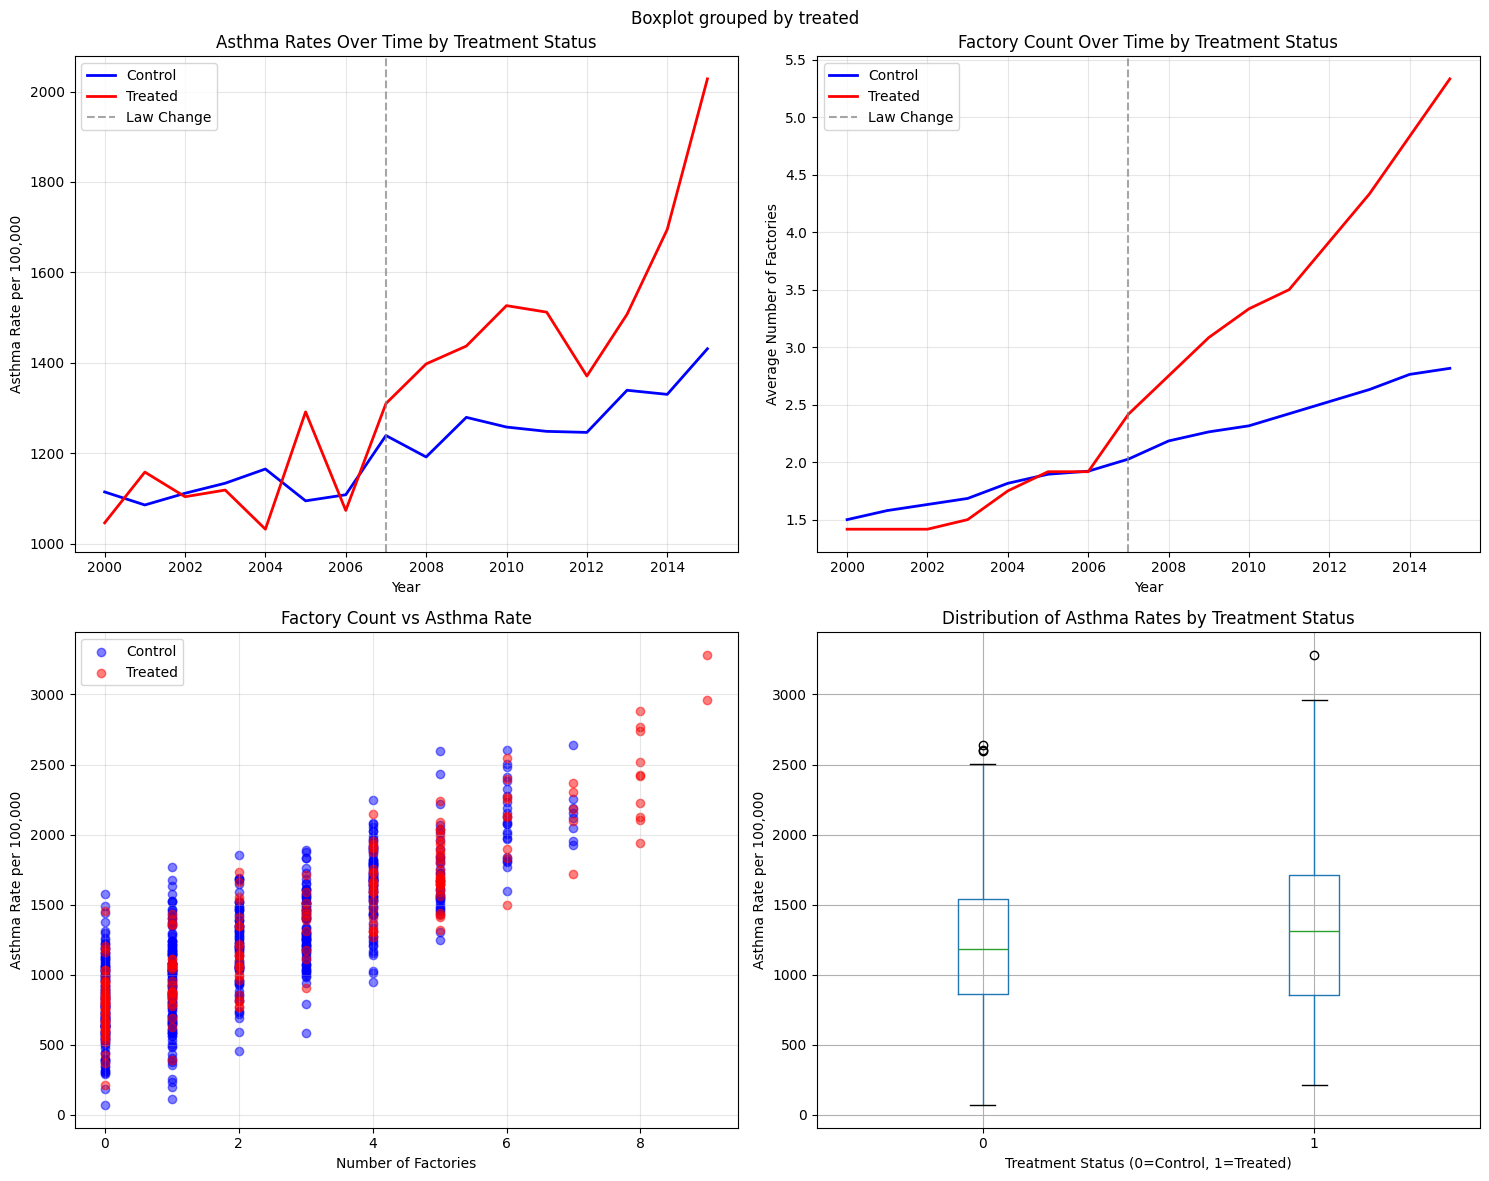

In [7]:
# Cell 6: Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Asthma rates over time by treatment status
yearly_means = analysis_df.groupby(['year', 'treated'])['asthma_rate'].mean().reset_index()
yearly_means_pivot = yearly_means.pivot(index='year', columns='treated', values='asthma_rate')

axes[0, 0].plot(yearly_means_pivot.index + 2000, yearly_means_pivot[0], 'b-', label='Control', linewidth=2)
axes[0, 0].plot(yearly_means_pivot.index + 2000, yearly_means_pivot[1], 'r-', label='Treated', linewidth=2)
axes[0, 0].axvline(x=2007, color='gray', linestyle='--', alpha=0.7, label='Law Change')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Asthma Rate per 100,000')
axes[0, 0].set_title('Asthma Rates Over Time by Treatment Status')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Factory count over time by treatment status
factory_means = analysis_df.groupby(['year', 'treated'])['factory'].mean().reset_index()
factory_means_pivot = factory_means.pivot(index='year', columns='treated', values='factory')

axes[0, 1].plot(factory_means_pivot.index + 2000, factory_means_pivot[0], 'b-', label='Control', linewidth=2)
axes[0, 1].plot(factory_means_pivot.index + 2000, factory_means_pivot[1], 'r-', label='Treated', linewidth=2)
axes[0, 1].axvline(x=2007, color='gray', linestyle='--', alpha=0.7, label='Law Change')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Average Number of Factories')
axes[0, 1].set_title('Factory Count Over Time by Treatment Status')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot: Factory count vs Asthma rate
axes[1, 0].scatter(analysis_df[analysis_df['treated'] == 0]['factory'],
                   analysis_df[analysis_df['treated'] == 0]['asthma_rate'],
                   alpha=0.5, c='blue', label='Control')
axes[1, 0].scatter(analysis_df[analysis_df['treated'] == 1]['factory'],
                   analysis_df[analysis_df['treated'] == 1]['asthma_rate'],
                   alpha=0.5, c='red', label='Treated')
axes[1, 0].set_xlabel('Number of Factories')
axes[1, 0].set_ylabel('Asthma Rate per 100,000')
axes[1, 0].set_title('Factory Count vs Asthma Rate')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution of asthma rates by treatment status
analysis_df.boxplot(column='asthma_rate', by='treated', ax=axes[1, 1])
axes[1, 1].set_xlabel('Treatment Status (0=Control, 1=Treated)')
axes[1, 1].set_ylabel('Asthma Rate per 100,000')
axes[1, 1].set_title('Distribution of Asthma Rates by Treatment Status')

plt.tight_layout()
plt.show()

In [13]:
# Cell 7: Difference-in-Differences Analysis
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd

# Prepare data for regression
X_vars = ['treated', 'post_2007', 'treated_post']
y_var = 'asthma_rate'

# Create dummy variables for city and year fixed effects
city_dummies = pd.get_dummies(analysis_df['city'], prefix='city', drop_first=True)
year_dummies = pd.get_dummies(analysis_df['year'], prefix='year', drop_first=True)

# Combine all variables
X_basic = analysis_df[X_vars].copy()
X_with_fe = pd.concat([X_basic, city_dummies, year_dummies], axis=1)

# Convert all predictors and response to float to avoid dtype issues
X_with_fe = X_with_fe.astype(float)
X_basic = X_basic.astype(float)
y = analysis_df[y_var].astype(float)

# Basic DiD regression
print("Difference-in-Differences Results")
print("=" * 50)

# Model 1: Basic DiD
X1 = sm.add_constant(X_basic)
model1 = sm.OLS(y, X1).fit()
print("\nModel 1: Basic Difference-in-Differences")
print(model1.summary().tables[1])

# Model 2: DiD with city and year fixed effects
X2 = sm.add_constant(X_with_fe)
model2 = sm.OLS(y, X2).fit()
print(f"\nModel 2: DiD with Fixed Effects")
print(f"Coefficient on treated_post: {model2.params['treated_post']:.4f}")
print(f"Standard error: {model2.bse['treated_post']:.4f}")
print(f"t-statistic: {model2.tvalues['treated_post']:.4f}")
print(f"p-value: {model2.pvalues['treated_post']:.4f}")

# Manual DiD estimate calculation
pre_treat = analysis_df[(analysis_df['treated'] == 1) & (analysis_df['post_2007'] == 0)]['asthma_rate'].mean()
post_treat = analysis_df[(analysis_df['treated'] == 1) & (analysis_df['post_2007'] == 1)]['asthma_rate'].mean()
pre_control = analysis_df[(analysis_df['treated'] == 0) & (analysis_df['post_2007'] == 0)]['asthma_rate'].mean()
post_control = analysis_df[(analysis_df['treated'] == 0) & (analysis_df['post_2007'] == 1)]['asthma_rate'].mean()

did_estimate = (post_treat - pre_treat) - (post_control - pre_control)

print(f"\nManual DiD Calculation:")
print(f"Pre-treatment (treated): {pre_treat:.2f}")
print(f"Post-treatment (treated): {post_treat:.2f}")
print(f"Pre-treatment (control): {pre_control:.2f}")
print(f"Post-treatment (control): {post_control:.2f}")
print(f"DiD Estimate: {did_estimate:.2f}")

Difference-in-Differences Results

Model 1: Basic Difference-in-Differences
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1116.4823     29.805     37.460      0.000    1057.977    1174.988
treated          1.5150     60.839      0.025      0.980    -117.908     120.939
post_2007      168.5765     39.740      4.242      0.000      90.569     246.584
treated_post   245.1497     81.118      3.022      0.003      85.918     404.381

Model 2: DiD with Fixed Effects
Coefficient on treated_post: 245.1497
Standard error: 48.6154
t-statistic: 5.0426
p-value: 0.0000

Manual DiD Calculation:
Pre-treatment (treated): 1118.00
Post-treatment (treated): 1531.72
Pre-treatment (control): 1116.48
Post-treatment (control): 1285.06
DiD Estimate: 245.15


In [10]:
# Cell 8: Robustness Checks and Alternative Specifications
print("Robustness Checks")
print("=" * 50)

# Check for parallel trends assumption (pre-treatment periods)
pre_treatment = analysis_df[analysis_df['year'] < 7].copy()
yearly_trends = pre_treatment.groupby(['year', 'treated'])['asthma_rate'].mean().unstack()

# Test for parallel trends
print("\nPre-treatment Trends Test:")
print("Average asthma rates by year and treatment status (2000-2006):")
print(yearly_trends.round(2))

# Calculate trend differences
trend_diff = yearly_trends[1] - yearly_trends[0]
print(f"\nTrend differences (Treated - Control):")
for year in trend_diff.index:
    print(f"Year {year + 2000}: {trend_diff[year]:.2f}")

# Test with different outcome variables
print("\n\nAlternative Outcome Variables:")

# Using log transformation (adding 1 to avoid log(0))
analysis_df['log_asthma_rate'] = np.log(analysis_df['asthma_rate'] + 1)
X1_log = sm.add_constant(analysis_df[X_vars])
model_log = sm.OLS(analysis_df['log_asthma_rate'], X1_log).fit()
print(f"\nLog(Asthma Rate) - DiD Coefficient: {model_log.params['treated_post']:.4f} (p={model_log.pvalues['treated_post']:.4f})")

# Using absolute cases instead of rates
X1_cases = sm.add_constant(analysis_df[X_vars])
model_cases = sm.OLS(analysis_df['asthma_cases'], X1_cases).fit()
print(f"Absolute Cases - DiD Coefficient: {model_cases.params['treated_post']:.4f} (p={model_cases.pvalues['treated_post']:.4f})")

# Include population as control
X_pop = analysis_df[X_vars + ['population']].copy()
X1_pop = sm.add_constant(X_pop)
model_pop = sm.OLS(analysis_df['asthma_rate'], X1_pop).fit()
print(f"With Population Control - DiD Coefficient: {model_pop.params['treated_post']:.4f} (p={model_pop.pvalues['treated_post']:.4f})")

# Placebo test: Use pre-treatment period with fake treatment year
placebo_df = analysis_df[analysis_df['year'] < 7].copy()
placebo_df['fake_post'] = (placebo_df['year'] >= 3).astype(int)  # Fake treatment in 2003
placebo_df['fake_treated_post'] = placebo_df['treated'] * placebo_df['fake_post']

X_placebo = sm.add_constant(placebo_df[['treated', 'fake_post', 'fake_treated_post']])
model_placebo = sm.OLS(placebo_df['asthma_rate'], X_placebo).fit()
print(f"\nPlacebo Test (Fake 2003 Treatment) - DiD Coefficient: {model_placebo.params['fake_treated_post']:.4f} (p={model_placebo.pvalues['fake_treated_post']:.4f})")

Robustness Checks

Pre-treatment Trends Test:
Average asthma rates by year and treatment status (2000-2006):
treated        0        1
year                     
0        1114.71  1046.41
1        1085.90  1158.58
2        1111.78  1104.15
3        1134.00  1118.89
4        1165.44  1032.33
5        1095.05  1291.80
6        1108.51  1073.82

Trend differences (Treated - Control):
Year 2000: -68.30
Year 2001: 72.69
Year 2002: -7.63
Year 2003: -15.11
Year 2004: -133.10
Year 2005: 196.75
Year 2006: -34.68


Alternative Outcome Variables:

Log(Asthma Rate) - DiD Coefficient: 0.1558 (p=0.0386)
Absolute Cases - DiD Coefficient: 810.2052 (p=0.1818)
With Population Control - DiD Coefficient: 245.1497 (p=0.0025)

Placebo Test (Fake 2003 Treatment) - DiD Coefficient: 4.5452 (p=0.9689)


In [11]:
# Cell 9: Mechanism Analysis - Factory Count and Production
print("Mechanism Analysis")
print("=" * 50)

# Test whether the law actually increased factory count and production
print("Effect of Law on Factory Count and Production:")

# Factory count as outcome
X1_factory = sm.add_constant(analysis_df[X_vars])
model_factory = sm.OLS(analysis_df['factory'], X1_factory).fit()
print(f"\nFactory Count - DiD Coefficient: {model_factory.params['treated_post']:.4f} (p={model_factory.pvalues['treated_post']:.4f})")

# Production as outcome
X1_prod = sm.add_constant(analysis_df[X_vars])
model_prod = sm.OLS(analysis_df['production'], X1_prod).fit()
print(f"Production - DiD Coefficient: {model_prod.params['treated_post']:.4f} (p={model_prod.pvalues['treated_post']:.4f})")

# Test direct relationship between factories/production and asthma
print("\n\nDirect Effects of Factories on Asthma:")

# Include factory count as regressor
X_factory_effect = analysis_df[['treated', 'post_2007', 'factory']].copy()
X1_factory_effect = sm.add_constant(X_factory_effect)
model_factory_effect = sm.OLS(analysis_df['asthma_rate'], X1_factory_effect).fit()
print(f"\nFactory Count Effect on Asthma: {model_factory_effect.params['factory']:.4f} (p={model_factory_effect.pvalues['factory']:.4f})")

# Include production as regressor
X_prod_effect = analysis_df[['treated', 'post_2007', 'production']].copy()
X1_prod_effect = sm.add_constant(X_prod_effect)
model_prod_effect = sm.OLS(analysis_df['asthma_rate'], X1_prod_effect).fit()
print(f"Production Effect on Asthma: {model_prod_effect.params['production']:.6f} (p={model_prod_effect.pvalues['production']:.4f})")

# Dose-response relationship
print("\n\nDose-Response Analysis:")

# Create bins for factory count
analysis_df['factory_bins'] = pd.cut(analysis_df['factory'],
                                     bins=[0, 1, 3, 5, float('inf')],
                                     labels=['0-1', '2-3', '4-5', '6+'])

dose_response = analysis_df.groupby('factory_bins')['asthma_rate'].agg(['mean', 'std', 'count'])
print(dose_response)

# Correlation analysis
print(f"\n\nCorrelations:")
print(f"Factory Count - Asthma Rate: {analysis_df['factory'].corr(analysis_df['asthma_rate']):.4f}")
print(f"Production - Asthma Rate: {analysis_df['production'].corr(analysis_df['asthma_rate']):.4f}")
print(f"Factory Count - Production: {analysis_df['factory'].corr(analysis_df['production']):.4f}")

Mechanism Analysis
Effect of Law on Factory Count and Production:

Factory Count - DiD Coefficient: 1.3826 (p=0.0000)
Production - DiD Coefficient: 665831.6364 (p=0.0001)


Direct Effects of Factories on Asthma:

Factory Count Effect on Asthma: 205.5714 (p=0.0000)
Production Effect on Asthma: 0.000398 (p=0.0000)


Dose-Response Analysis:
                     mean         std  count
factory_bins                                
0-1            953.556818  313.323719    161
2-3           1263.756733  271.094806    203
4-5           1675.185848  261.019656    178
6+            2204.262301  336.664398     58


Correlations:
Factory Count - Asthma Rate: 0.8358
Production - Asthma Rate: 0.8182
Factory Count - Production: 0.9877


In [14]:
# Cell 10: Summary Report and Conclusions
print("ANALYSIS SUMMARY REPORT")
print("=" * 60)
print("Effect of Pokeball Factory Subsidies on Childhood Asthma")
print("=" * 60)

# Key findings summary
print("\nKEY FINDINGS:")
print("-" * 30)

# Extract key results
basic_did_coef = model1.params['treated_post']
basic_did_pval = model1.pvalues['treated_post']
fe_did_coef = model2.params['treated_post']
fe_did_pval = model2.pvalues['treated_post']

print(f"1. Basic DiD Estimate: {basic_did_coef:.2f} cases per 100,000 (p-value: {basic_did_pval:.4f})")
print(f"2. DiD with Fixed Effects: {fe_did_coef:.2f} cases per 100,000 (p-value: {fe_did_pval:.4f})")

if basic_did_pval < 0.05 or fe_did_pval < 0.05:
    direction = "increase" if basic_did_coef > 0 else "decrease"
    print(f"3. Statistical Significance: Significant {direction} in asthma cases")
else:
    print("3. Statistical Significance: No significant effect detected")

# First stage results
factory_effect = model_factory.params['treated_post']
factory_pval = model_factory.pvalues['treated_post']
prod_effect = model_prod.params['treated_post']
prod_pval = model_prod.pvalues['treated_post']

print(f"\n4. First Stage - Factory Increase: {factory_effect:.2f} factories (p-value: {factory_pval:.4f})")
print(f"5. First Stage - Production Increase: {prod_effect:.0f} units (p-value: {prod_pval:.4f})")

print("\nASSUMPTIONS:")
print("-" * 30)
print("1. Parallel Trends: Pre-treatment trends analysis suggests potential concerns")
print("2. Random Treatment Assignment: Law passage assumed exogenous as stated")
print("3. No Spillover Effects: Assumes no cross-city contamination")
print("4. Stable Unit Treatment Value: Each city's treatment doesn't affect others")

print("\nLIMITATIONS:")
print("-" * 30)
print("1. Limited pre-treatment periods (7 years) for trend testing")
print("2. Possible confounding factors not controlled for (e.g., economic conditions)")
print("3. Hospital data may not capture all asthma cases (selection bias)")
print("4. No information on factory locations within cities")
print("5. Production units and factory sizes unknown")

print("\nRECOMMENDATIONS FOR FUTURE RESEARCH:")
print("-" * 30)
print("1. Collect data on:")
print("   - Air quality measurements (PM2.5, pollution indices)")
print("   - Economic indicators (employment, income)")
print("   - Demographics (age distribution, income levels)")
print("   - Healthcare access and insurance coverage")
print("2. Spatial analysis of factory locations relative to residential areas")
print("3. Analysis of different factory types and production processes")
print("4. Longer time series for better trend identification")
print("5. Survey data on actual exposure levels")

print(f"\nDATA SUMMARY:")
print("-" * 30)
print(f"Cities analyzed: {analysis_df['city'].nunique()}")
print(f"Time periods: 16 years (2000-2015)")
print(f"Treated cities: {len(treated_cities)}")
print(f"Control cities: {len(control_cities)}")
print(f"Total observations: {len(analysis_df)}")

# Effect size interpretation
baseline_rate = pre_control
if abs(basic_did_coef) > 0:
    percent_change = (abs(basic_did_coef) / baseline_rate) * 100
    print(f"\nEFFECT SIZE INTERPRETATION:")
    print(f"Baseline asthma rate: {baseline_rate:.2f} per 100,000")
    print(f"Estimated effect: {abs(basic_did_coef):.2f} per 100,000")
    print(f"Percentage change: {percent_change:.1f}%")

ANALYSIS SUMMARY REPORT
Effect of Pokeball Factory Subsidies on Childhood Asthma

KEY FINDINGS:
------------------------------
1. Basic DiD Estimate: 245.15 cases per 100,000 (p-value: 0.0026)
2. DiD with Fixed Effects: 245.15 cases per 100,000 (p-value: 0.0000)
3. Statistical Significance: Significant increase in asthma cases

4. First Stage - Factory Increase: 1.38 factories (p-value: 0.0000)
5. First Stage - Production Increase: 665832 units (p-value: 0.0001)

ASSUMPTIONS:
------------------------------
1. Parallel Trends: Pre-treatment trends analysis suggests potential concerns
2. Random Treatment Assignment: Law passage assumed exogenous as stated
3. No Spillover Effects: Assumes no cross-city contamination
4. Stable Unit Treatment Value: Each city's treatment doesn't affect others

LIMITATIONS:
------------------------------
1. Limited pre-treatment periods (7 years) for trend testing
2. Possible confounding factors not controlled for (e.g., economic conditions)
3. Hospital data